In [1]:
import networkx as nx
import numpy as np
# ignore errors yielded by zero divisions
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
import powerlaw
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau
from IPython.display import HTML, display

from util import name, inv_dict, sort_key, correlation

%matplotlib inline

p = print

Il codice usato per scaricare il grafo si trova nel file `download_graph.py`.

# Analisi del grafo di Stack Overflow

##  Struttura del grafo

Il grafo analizzato è quello così composto:

- i **nodi** corrispondono agli **utenti**;
- gli **archi** rispondono alla relazione *ha risposto a*;
- il **peso** degli archi parte da una base di 1, per poi aumentare di un'unità ogni volta che un utente ha risposto nuovamente ad un altro utente (questo dato non sarà utilizzato durante l'analisi, infatti i pesi saranno ignorati).

Lo snapshot della rete risale al 26 maggio 2017.

## Costruzione del grafo

La rete è stata costruita a partire dal nodo con la reputazione più alta, basandosi sul concetto di reputazione fornito da Stack Overflow, l'utente [Jon Skeet](https://stackoverflow.com/users/22656/jon-skeet), id utente 22656.

Partendo da questo nodo si è sviluppata una visita per ampiezza (BFS), seguendo questo criterio: è stata creata una coda FIFO di nodi da visitare ed è stata popolata estraendo, sempre secondo il criterio di distanza da Jon Skeet, le domande fatte da ogni utente e le relative risposte date, aggiungendo in ordine alla coda i nodi proprietari della risposta.

In questo modo ci si è assicurati di visitare prima i nodi che hanno risposto alle domande di Jon, successivamente quelli che hanno risposto a coloro che hanno risposto alle domande di Jon e così via.

In [2]:
G = nx.read_gpickle('graph.pkl')

## Parametri cumulativi

In [3]:
order, size = G.order(), G.size()
strongly_connected = nx.is_strongly_connected(G)

in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())
min_in_degree = min(in_degree.values())
max_in_degree = max(in_degree.values())
min_out_degree = min(out_degree.values())
max_out_degree = max(out_degree.values())

avg_in_degree = np.mean(list(in_degree.values()))
avg_out_degree = np.mean(list(out_degree.values()))

p(f'La dimensione della rete è di {order} nodi e {size} archi.')
p('Il grafo {}è fortemente connesso.'.format('' if strongly_connected else 'non '))
p(f'Il grado in entrata minimo è {min_in_degree} mentre quello massimo è ' + \
  f'{max_in_degree}, ed appartiene a {name(max(in_degree, key=in_degree.get), G)}.')
p(f'Il grado in uscita minimo è {min_out_degree} mentre quello massimo è ' + \
  f'{max_out_degree}, ed appartiene a {name(max(out_degree, key=out_degree.get), G)}.')
p(f'Il grado medio in entrata è {avg_in_degree:.3f}.')
p(f'Il grado medio in uscita è {avg_out_degree:.3f}.')

La dimensione della rete è di 30182 nodi e 56344 archi.
Il grafo non è fortemente connesso.
Il grado in entrata minimo è 0 mentre quello massimo è 3102, ed appartiene a acidzombie24.
Il grado in uscita minimo è 1 mentre quello massimo è 142, ed appartiene a Jon Skeet.
Il grado medio in entrata è 1.867.
Il grado medio in uscita è 1.867.


## Distribuzione del grado

Alcuni grafici illustreranno come è distribuito il grado all'interno della porzione di rete analizzata. Come convenzione, d'ora in avanti, il colore <font color="red">rosso</font> contraddistinguerà il grado in entrata (negativo), mentre quello <font color="blue">blu</font> quello in uscita (positivo).

### Distribuzione del grado negativo

Siccome ogni arco del grafo risponde alla domanda "ha risposto a", il grado negativo, nel caso del grafo analizzato, fornisce un'idea generica della quantità di domande che un'utente ha posto sulla piattaforma, ma soprattutto sulla qualità e l'interesse che le domande hanno suscitato nella comunità, tanto da ricevere una risposta.

La figura seguente presenta il grafico (lineare) della distribuzione del grado in entrata.

La somma della probabilità è 1.00.


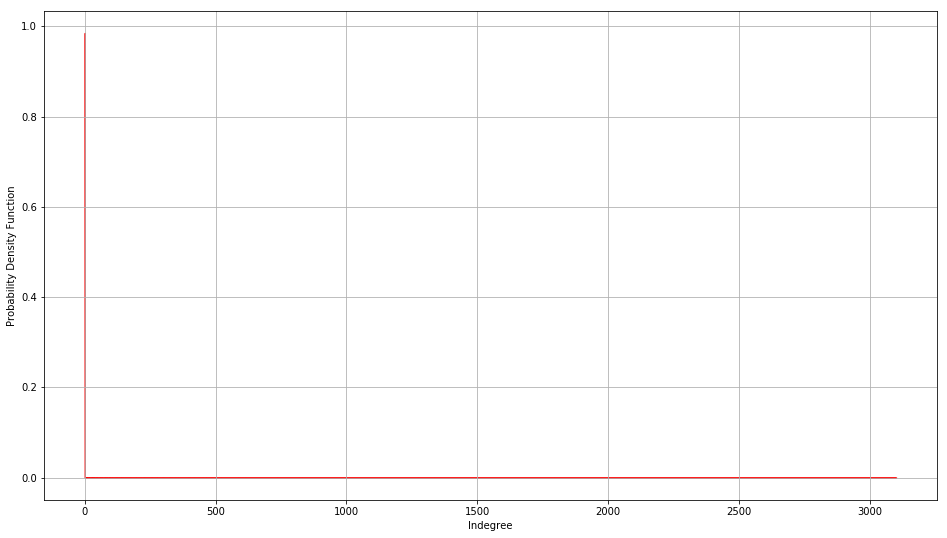

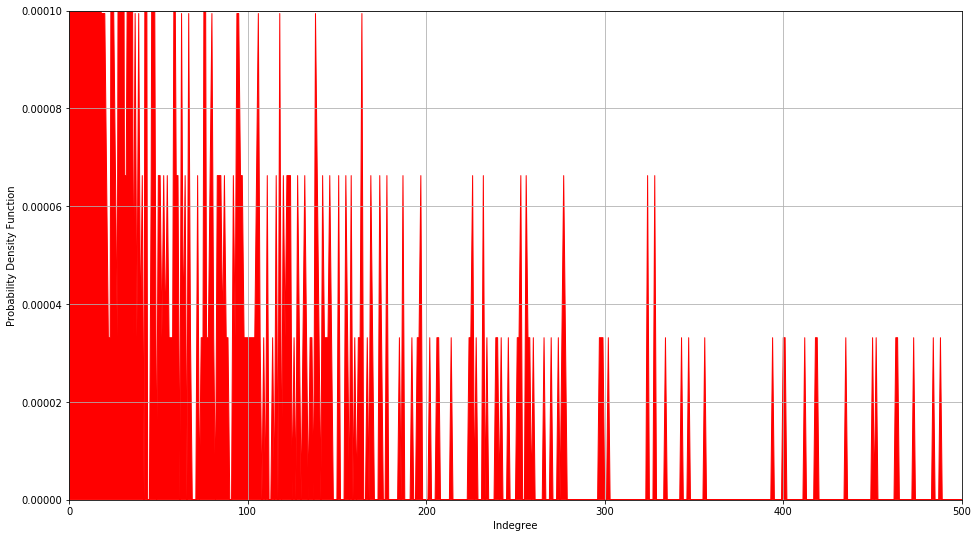

In [4]:
sample = list(in_degree.values())
count, bins = np.histogram(sample, bins=range(min_in_degree, max_in_degree+1),
                           density=False)

pdf = count.astype(float) / float(order)

p(f'La somma della probabilità è {sum(pdf):.2f}.')

fig = plt.figure(figsize=(16,9))
axes = fig.gca()
axes.fill_between(bins[:-1], pdf, color='red')
axes.set_xlabel('Indegree')
axes.set_ylabel('Probability Density Function')
plt.grid(True)

fig = plt.figure(figsize=(16,9))
axes = fig.gca()
axes.fill_between(bins[:-1], pdf, color='red')
axes.set_ylim((0, 0.0001))
axes.set_xlim((0, 500))
axes.set_xlabel('Indegree')
axes.set_ylabel('Probability Density Function')
plt.grid(True)

Invece, successivamente, viene visualizzato il grafico bilogaritmico degli stessi dati.

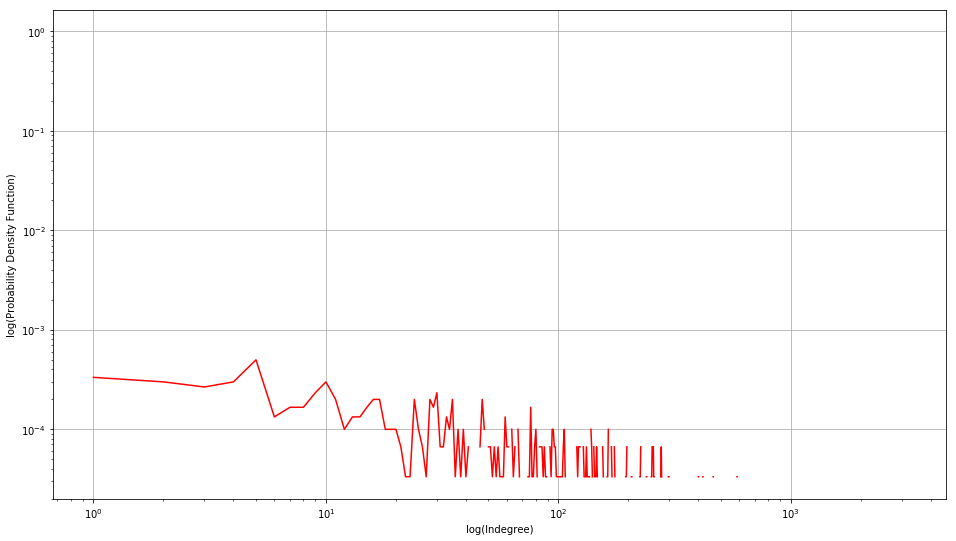

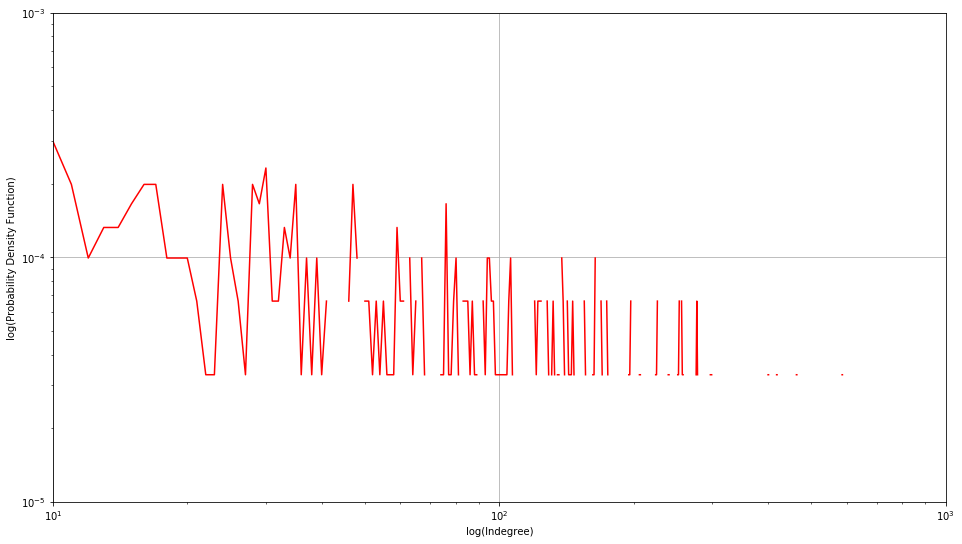

In [5]:
fig = plt.figure(figsize=(16,9))
axes = fig.gca()
axes.loglog(bins[:-1], pdf, color='red')
axes.set_xlabel('log(Indegree)')
axes.set_ylabel('log(Probability Density Function)')
plt.grid(True)

fig = plt.figure(figsize=(16,9))
axes = fig.gca()
axes.loglog(bins[:-1], pdf, color='red')
axes.set_ylim((10**-5, 10**-3))
axes.set_xlim((10, 10**3))
axes.set_xlabel('log(Indegree)')
axes.set_ylabel('log(Probability Density Function)')
plt.grid(True)

### Distribuzione del grado positivo

Ogni arco, di nuovo, corrisponde a una relazione di risposta: per questo motivo un arco uscente da un nodo indica che ha risposto ad una domanda, e che quindi ha partecipato alla comunità dando una risposta ad una domanda che ha suscitato un interesse.

Di seguito, la visualizzazione (lineare) della distribuzione del grado in uscita.

La somma della probabilità è 1.00.


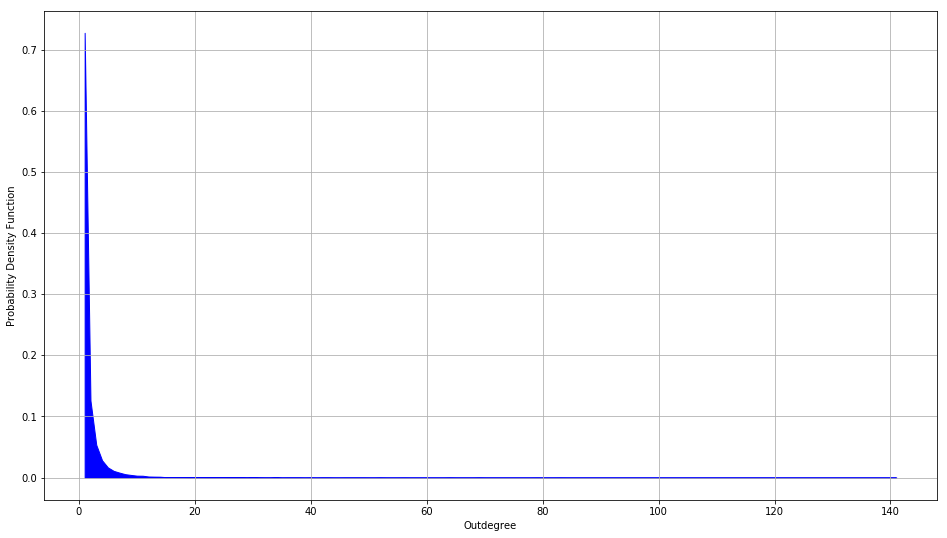

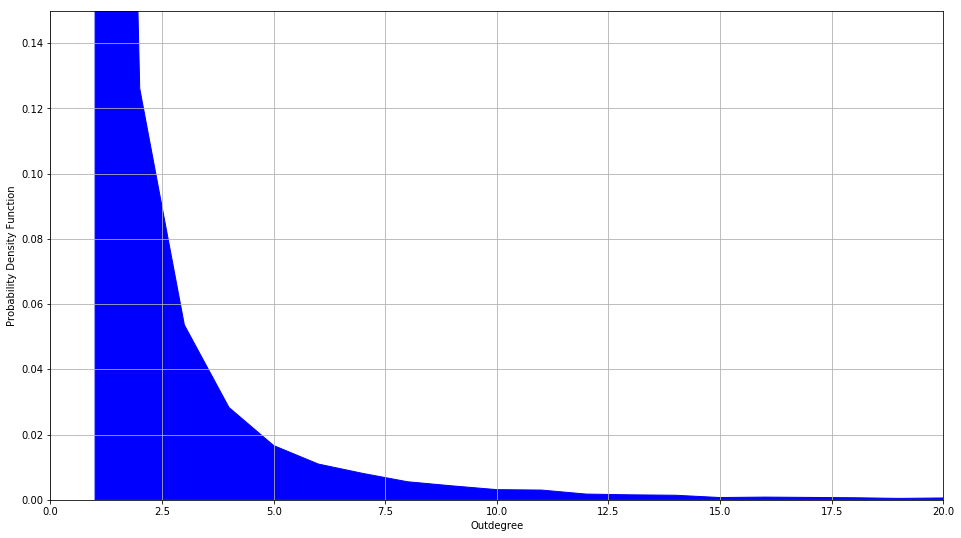

In [6]:
sample = list(out_degree.values())
count, bins = np.histogram(sample, bins=range(min_out_degree, max_out_degree+1),
                           density=False)

pdf = count.astype(float) / float(order)
p(f'La somma della probabilità è {sum(pdf):.2f}.')

fig = plt.figure(figsize=(16,9))
axes = fig.gca()
axes.fill_between(bins[:-1], pdf, color='blue')
axes.set_xlabel('Outdegree')
axes.set_ylabel('Probability Density Function')
plt.grid(True)

fig = plt.figure(figsize=(16,9))
axes = fig.gca()
axes.fill_between(bins[:-1], pdf, color='blue')
axes.set_ylim((0, 0.15))
axes.set_xlim((0, 20))
axes.set_xlabel('Outdegree')
axes.set_ylabel('Probability Density Function')
plt.grid(True)

Invece, successivamente, viene visualizzato il grafico bilogaritmico degli stessi dati.

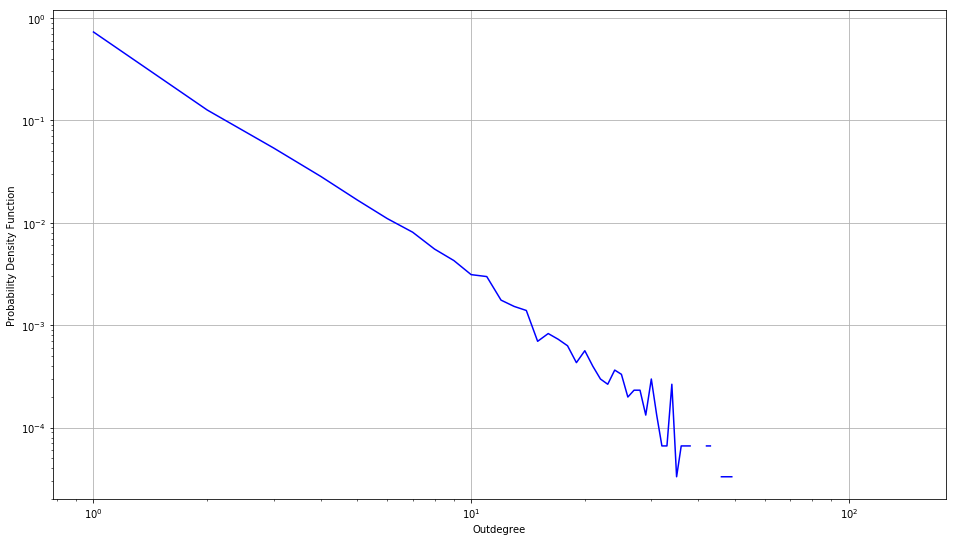

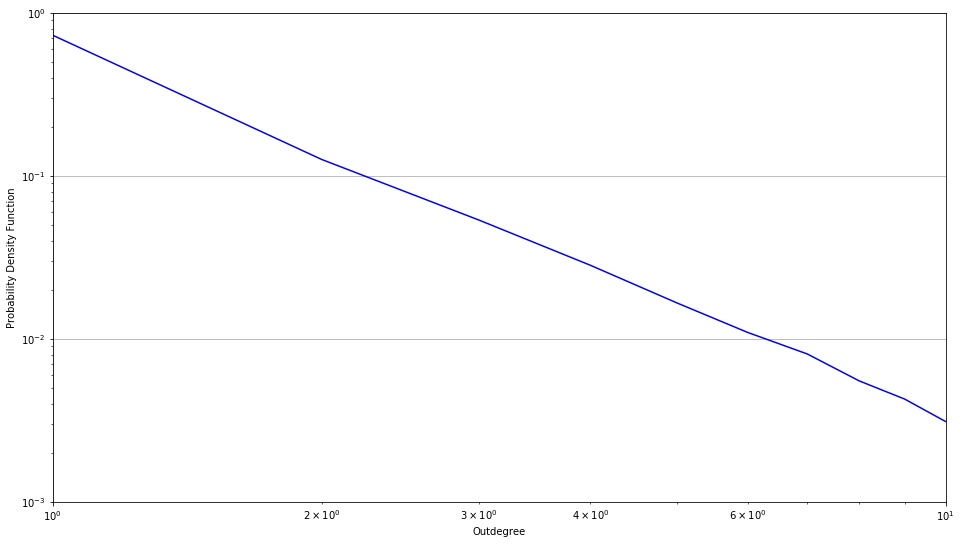

In [7]:
fig = plt.figure(figsize=(16,9))
axes = fig.gca()
axes.loglog(bins[:-1], pdf, color='blue')
axes.set_xlabel('Outdegree')
axes.set_ylabel('Probability Density Function')
plt.grid(True)

fig = plt.figure(figsize=(16,9))
axes = fig.gca()
axes.loglog(bins[:-1], pdf, color='blue')
axes.set_ylim((10**-3, 1))
axes.set_xlim((0, 10))
axes.set_xlabel('Outdegree')
axes.set_ylabel('Probability Density Function')
plt.grid(True)

Come si può notare dai grafici, la distribuzione del grado in uscita segue una **legge di potenza**. Di seguito un grafico che mostra quanto il grado positivo si adatti ad una legge di potenza.

La distribuzione si approssima ad una powerlaw con esponente 2.482.


Calculating best minimal value for power law fit


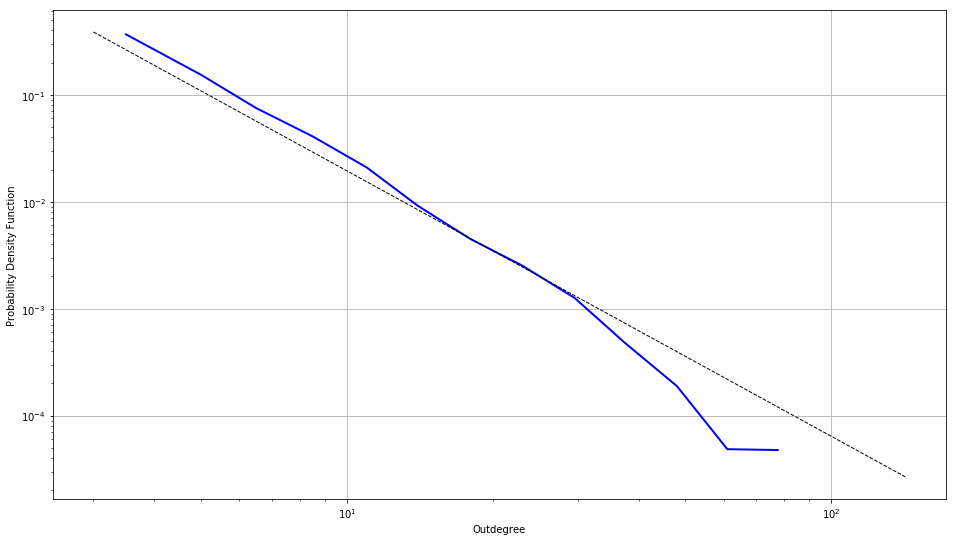

In [22]:
fit = powerlaw.Fit(sample, discrete=True)
alpha = fit.power_law.alpha
p(f"La distribuzione si approssima ad una powerlaw con esponente {alpha:.3f}.")

plt.figure(figsize=(16,9))
plt.grid(True)

fit_axes = fit.plot_pdf(color='blue', linewidth=2)
fit.power_law.plot_pdf(color='black', linestyle='--', linewidth=1, ax=fit_axes)

fit_axes.set_xlabel('Outdegree')
fit_axes.set_ylabel('Probability Density Function')

Il perchè il grafico del grado negativo sia così poco regolare si potrebbe ricercare nel fatto che anche il grado positivo, dopo $x=10$, tende ad approssimarsi sempre meno alla curva delle legge di potenza. Questo potrebbe in larga parte dipendere dal fatto che l'acquisizione dei dati è stata forzatamente fermata alle risposte date alle domande dell'ultimo nodo prima di arrivare ad un ordine della rete di $3 \times 10^4$.

In questo modo, per una parte dei nodi della rete, non è stato possibile analizzare i nodi collegati alle risposte date alla domande che questi ultimi hanno posto, introducendo così un *bias* tra la rete reale di Stack Overflow e la piccola porzione analizzata.

## Relazione tra il numero di domande e di risposte

È importante anche analizzare la relazione che sussiste tra il numero di domande effettuate sulla piattaforma e il numero di risposte ricevute. È fondamentale, osservando i grafici relativi, tenere a mente che a causa del troncamento nell'acquisizione dei dati, di cui si è parlato prima, questi numeri sono rapportati alla porzione di rete acquisita e potrebbero differire *sensibilmente* dalla reale struttura della rete.

Di seguito viene rappresentata la CCDF, cioè la *Complementary Cumulative Distribution Function*, sia del grado in entrata, quindi le risposte, che del grado in uscita, cioè le domande.

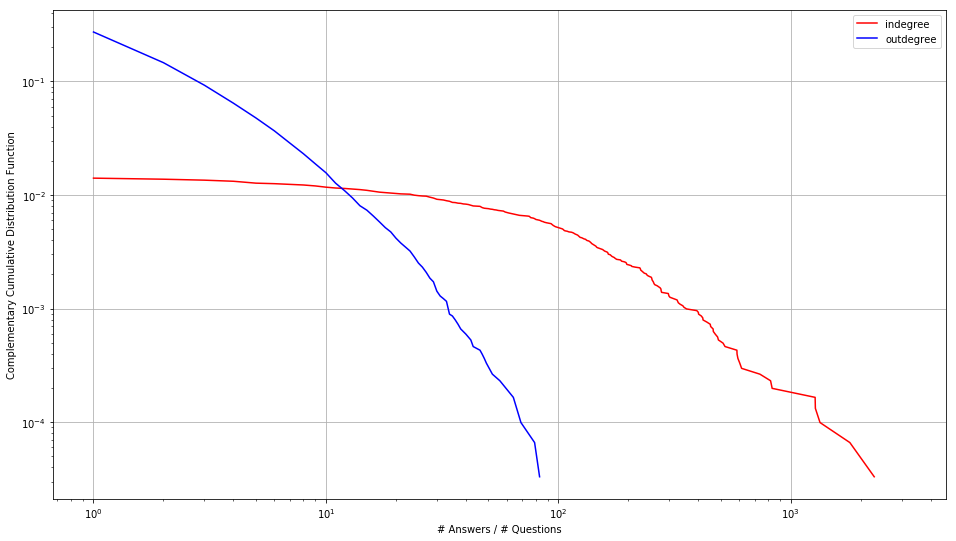

In [9]:
in_sample = list(in_degree.values())
in_ecdf = ECDF(in_sample)
in_bins = np.unique(in_sample)
in_cdf = in_ecdf(in_bins)

out_sample = list(out_degree.values())
out_ecdf = ECDF(out_sample)
out_bins = np.unique(out_sample)
out_cdf = out_ecdf(out_bins)

fig = plt.figure(figsize=(16,9))
plt.grid(True)
axes = fig.gca()

axes.loglog(in_bins, 1 - in_cdf, color='red')
axes.loglog(out_bins, 1 - out_cdf, color='blue')

plt.legend(['indegree', 'outdegree'], loc='best')
axes.set_xlabel('# Answers / # Questions')
axes.set_ylabel('Complementary Cumulative Distribution Function')

Il grafico mostra l'andamento della CCDF, quindi per ogni grado riscontrato la frazione di utenti che hanno un grado maggiore (si noti che il grafico inizia da $10^0 = 1$, quindi gli utenti con $0 < \delta^\pm \leq 1$ non vengono visualizzati dalla curva).

Inizialmente, si può notare come il grado in uscita sia sensibilmente minore di quello in entrata; ciò significa che gli utenti, nello specifico quelli con grado più alto, tendono a fare meno domande e a dare più risposte.

In secondo luogo, la curva del grado positivo per $x = 10^0 = 1$ vale molto di più di quella del grado negativo, quindi ci sono molti utenti che non hanno mai dato una risposta e molti meno che invece non hanno mai posto una domanda (anche se un numero così sensibilmente alto di grado negativo può essere dato, come già detto, dal metodo di acquisizione dei dati).

Si può poi vedere, in conclusione, come, ai gradi alti sia positivi che negativi, questi ultimi abbiano molto più spazio tra un gradino e l'altro; questo denota, dal punto di vista delle domande, uno "zoccolo duro" di utenti di grado molto simile che hanno proposto molte domande, mentre dal punto di vista delle risposte, un grande distacco tra i gradi più alti.

## Reciprocità

La reciprocità è calcolata come il rapporto tra il numero di cicli di lunghezza 2 e il numero totale di archi nel grafo. Formalmente:

$$
r = \frac{\mid\{(u,v) \in G \mid (v,u) \in G\}\mid}{\mid\{(u,v) \in G\}\mid}
$$

con $G = (V, E)$, grafo orientato.

In [10]:
G_undir = G.to_undirected()
p('Nel passaggio da grafo orientato a grafo non orientato è stato ' + \
  f'perso lo {100 - (G_undir.size() * 100.0 / G.size()):.2f}% di archi.')

p(f'La reciprocità generale del grafo è {nx.overall_reciprocity(G):.5f}.')
p(f'Per il nodo di partenza, {name(22656, G)}, la reciprocità è ' + \
  f'{nx.reciprocity(G, nodes=(22656,))[22656]:.5f}.')

Nel passaggio da grafo orientato a grafo non orientato è stato perso lo 0.31% di archi.
La reciprocità generale del grafo è 0.00625.
Per il nodo di partenza, Jon Skeet, la reciprocità è 0.39011.


Sì può notare come la reciprocità non solo sia bassa, ma, per la porzione di rete analizzata, sia patologicamente prossima allo zero. Questo poichè Stack Overflow, come tutte le reti di Stack Exchange, si basa su un meccanismo che di domanda-risposta di questo tipo: solitamente chi pone una domanda è un *neofita*, mentre chi risponde è un *esperto*. Difficilmente questa relazione sarà invertita: all'interno dello stesso dominio di competenze, il neofita potrà diventare esperto, ma l'esperto diventerà sempre più esperto, necessitando così raramente dell'aiuto di un altro membro con meno esperienza.

## Domande, risposte e reputazione

È interessante analizzare la relazione che sussiste tra il numero di domande e risposte presenti sulla piattaforma e il valore della reputazione associato ad ogni utente. Quest'ultimo è usato da Stack Overflow per retribuire il partecipante che contribuisce in maniera positiva alla community nel gioco *win-win*. Esiste anche una classifica per reputazione che sarà utilizzata più avanti nell'analisi del *ranking*.

La reputazione, per quanto riguarda le domande e le risposte, viene assegnata in questo modo:

- **+5**: la domanda viene votata positivamente;
- **+10**: la risposta viene votata positivamente;
- **+15**: la risposta viene marcata come "accettata";
- **-2**: la domanda viene votata negativamente;
- **-2**: la risposta viene votata negativamente;
- **-1**: ogni volta che l'utente vota una risposta negativamente.

Per valutare questa relazione verrà posto di volta in volta:

- sull'asse delle ascisse, il numero di risposte e domande presenti per ogni utente (quindi, rispettivamente, il grado in entrata e quello in uscita);
- sull'asse delle ordinate, la media e la mediana della reputazione per ogni utente che possiede quel determinato grado in entrata o in uscita.

### Risposte vs. reputazione

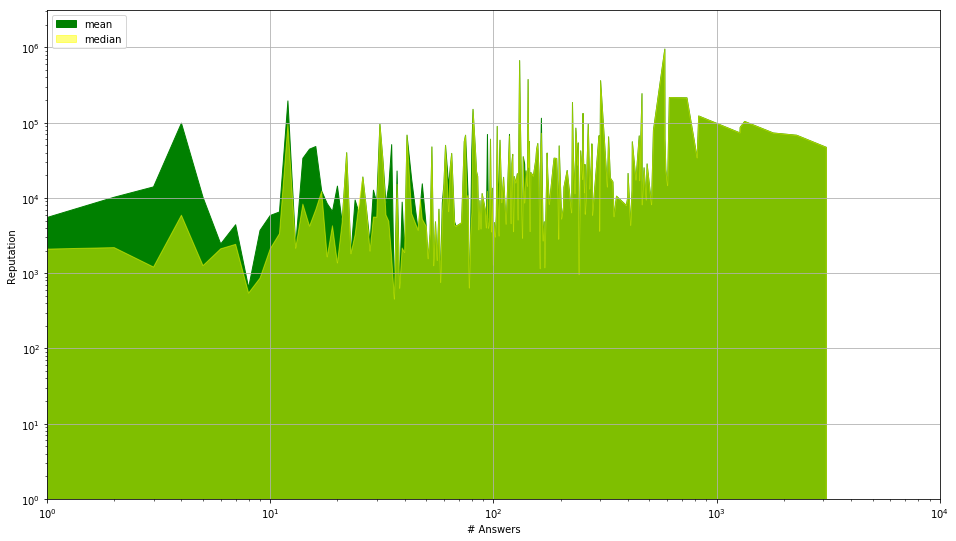

In [11]:
inv_indegree = inv_dict(in_degree)

# like {'indegree': 'mean', ...}
indeg_rep_mean = {}
# like {'indegree': 'median', ...}
indeg_rep_median = {}
for k,v in inv_indegree.items():
    # retrieve reputation for every user
    rep_list = [G.node[i]['reputation'] for i in v]
    indeg_rep_mean[k] = np.mean(rep_list)
    indeg_rep_median[k] = np.median(rep_list)

# order dicts for plotting
sort_indeg_rep_mean = sort_key(indeg_rep_mean)
sort_indeg_rep_median = sort_key(indeg_rep_median)

x_mean = list(sort_indeg_rep_mean.keys())
y_mean = list(sort_indeg_rep_mean.values())
x_median = list(sort_indeg_rep_median.keys())
y_median = list(sort_indeg_rep_median.values())

fig = plt.figure(figsize=(16,9))
plt.grid(True)
axes = fig.gca()
axes.set_xscale("log")
axes.set_yscale("log")

axes.fill_between(x_mean, y_mean, color='green')
axes.fill_between(x_median, y_median, color=(1, 1, 0, .5))

plt.legend(['mean', 'median'], loc='upper left')
axes.set_ylim((10**0, 10**6.5))
axes.set_xlim((10**0, 10**4))
axes.set_xlabel('# Answers')
axes.set_ylabel('Reputation')

## Domande vs. reputazione

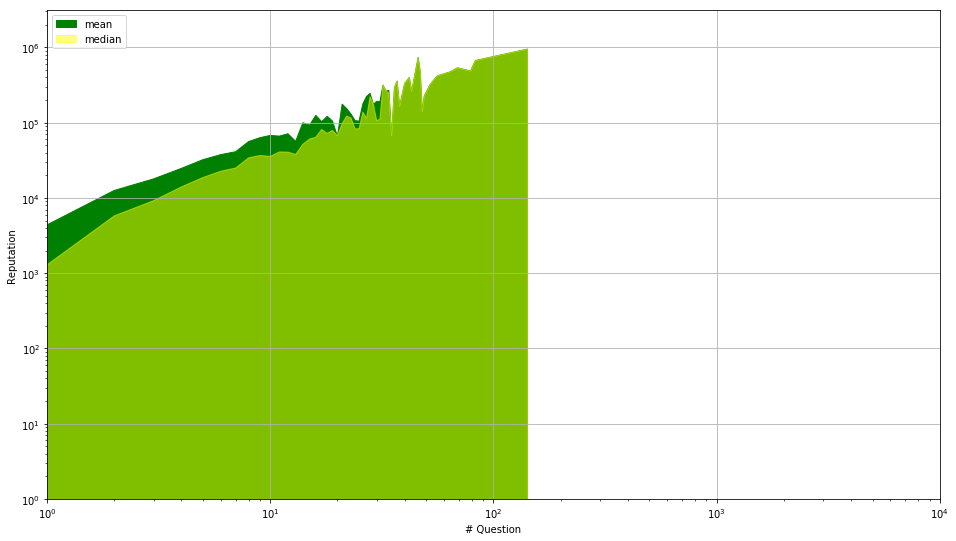

In [12]:
inv_outdegree = inv_dict(out_degree)

# like {'outdegree': 'mean', ...}
outdeg_rep_mean = {}
# like {'outdegree': 'median', ...}
outdeg_rep_median = {}
for k,v in inv_outdegree.items():
    # retrieve reputation for every user
    rep_list = [G.node[i]['reputation'] for i in v]
    outdeg_rep_mean[k] = np.mean(rep_list)
    outdeg_rep_median[k] = np.median(rep_list)

# order dicts for plotting
sort_outdeg_rep_mean = sort_key(outdeg_rep_mean)
sort_outdeg_rep_median = sort_key(outdeg_rep_median)

x_mean = list(sort_outdeg_rep_mean.keys())
y_mean = list(sort_outdeg_rep_mean.values())
x_median = list(sort_outdeg_rep_median.keys())
y_median = list(sort_outdeg_rep_median.values())

fig = plt.figure(figsize=(16,9))
plt.grid(True)
axes = fig.gca()
axes.set_xscale("log")
axes.set_yscale("log")

axes.fill_between(x_mean, y_mean, color='green')
axes.fill_between(x_median, y_median, color=(1, 1, 0, .5))

plt.legend(['mean', 'median'], loc='upper left')
axes.set_ylim((10**0, 10**6.5))
axes.set_xlim((10**0, 10**4))
axes.set_xlabel('# Question')
axes.set_ylabel('Reputation')

Si può notare una sostanziale differenza tra il grafico relativo alle risposte e quello relativo alle domande. 

Sebbene l'irregolarità del primo possa essere data dalla metodologia di acquisizione delle risposte per ogni utente, è possibile evincerne l'andamento; in molti casi ad un aumento del grado in entrata corrisponde un lieve aumento della reputazione (fatta eccezione per alcuni gradi, ma considerando l'insieme di dati a disposizione non è possibile sapere se ciò sia dovuto a caratteristiche proprie della rete o a una mancanza di ulteriore acquisizione di informazioni). La media, tra i gradi più bassi, resta sempre al di sopra della mediana, e ciò è sintomatico della presenza di *outliers*, cioè di nodi che hanno una reputazione più alta rispetto a quanto ci si aspetterebbe per il loro grado.

Per quanto riguarda il secondo grafico, la situazione è molto più delineata. È chiaro che ad un aumento del grado in uscita, corrisponde un netto incremento della reputazione. Questo significa che, nei criterio di attribuzione della reputazione, le domande (seppur avendo un peso minore) di qualità, sono le principali responsabili del punteggio alto. Anche in questo caso la media è, fino a un grado molto alto, superiore alla mediana.

## Ranking e confronto

Data la presenza di un ranking interno alla piattaforma e dato dalla *reputazione*, è interessante confrontarlo con qualche metodologia di ranking esogeno; in particolare verrà effettuato un paragone con un ranking spettrale, **PageRank**, e con un ranking di tipo geometrico, la **closeness** (non armonica).

In questo caso, PageRank, facendo largo uso del grado in entrata, potrebbe introdurre un leggero bias nei risultati prodotti.

Per l'analisi, verranno mostrate le prime 20 posizioni proposte dall'ordinamento in esame.

### Reputation ranking

In [13]:
# like {'reputation': (id, 'name')}
reps = {}
# like {'id': 'reputation', ...}
tau_reputation = {}

for n,d in G.nodes(data=True):
    reps[d['reputation']] = (n, d['name'])
    tau_reputation[n] = d['reputation']
    
sort_reps = sort_key(reps, reverse=True)
sort_tau_reputation = list(sort_key(tau_reputation).values())

s = """
<table style="display: 'inline-block'">
    <tr>
        <th>#</th>
        <th>Reputation</th>
        <th>ID</th>
        <th>Name</th>
    </tr>
"""

# lile ['name', ...]
rep_n = []
# lile ['reputation', ...]
rep_r = []

for n,d in enumerate(sort_reps.items()):
    if n < 20:
        s += """
            <tr>
                <td>{}</td>
                <td>{}</td>
                <td>{}</td>
                <td>{}</td>
            </tr>
        """.format(n+1, d[0], d[1][0], d[1][1])
        rep_n.append(d[1][1])
        rep_r.append(d[0])
    else:
        break
        

s += '</table>'

display(HTML(s))

### PageRank

In [14]:
pagerank = nx.pagerank(G, alpha=0.85, weight=None)

sort_tau_pagerank = list(sort_key(pagerank).values())

s = """
<table style="display: 'inline-block'">
    <tr>
        <th>#</th>
        <th>PageRank</th>
        <th>Reputation</th>
        <th>ID</th>
        <th>Name</th>
    </tr>
"""
# like ['name', ...]
pr = []

for n,k in enumerate(sorted(pagerank, key=pagerank.get, reverse=True)):
    if n < 20:
        node = G.node[k]
        name = node['name']
        rep = node['reputation']
        s += """
            <tr>
                <td>{}</td>
                <td>{:.6f}</td>
                <td>{}</td>
                <td>{}</td>
                <td>{}</td>
            </tr>
        """.format(n+1, pagerank[k], rep, k, name)
        pr.append(name)
    else:
        break

s += '</table>'

display(HTML(s))

### Closeness

In [15]:
closeness = nx.closeness_centrality(G)

sort_tau_closeness = list(sort_key(closeness).values())

s = """
<table style="display: 'inline-block'">
    <tr>
        <th>#</th>
        <th>Closeness</th>
        <th>Reputation</th>
        <th>ID</th>
        <th>Name</th>
    </tr>
"""

# like ['name', ...]
cl = []

for n,k in enumerate(sorted(closeness, key=closeness.get, reverse=True)):
    if n < 20:
        node = G.node[k]
        name = node['name']
        rep = node['reputation']
        s += """
            <tr>
                <td>{}</td>
                <td>{:.6f}</td>
                <td>{}</td>
                <td>{}</td>
                <td>{}</td>
            </tr>
        """.format(n+1, closeness[k], rep, k, name)
        cl.append(name)
    else:
        break

s += '</table>'

display(HTML(s))

### Comparazione: Reputazione vs. PageRank vs. Closeness

Per valutare la correlazione tra i vari algortmi di classificazione saranno effettuate due prove:

- sarà valutata l'interdipendenza utilizzando una funzione di correlazione sui primi venti risultati del ranking di questo tipo, considerati $U$ e $V$ della stessa dimensione:

$$
Corr_{U,V} = \frac{\mid\{x = y \mid x \in U, y \in V\}\mid}{\mid U \mid}
$$

    

- sarà valutata la $\tau$ di Kendall (Tau-b) per ognuno tra i ranking. Con $P$, il numero di coppie condordanti, $Q$, il numero di coppie discordanti, $J$, il numero di pareggi solo in $U$ e $K$, il numero di pareggi solo in $V$, la $\tau$ di Kendall è così calcolata:

$$
\tau_{U,V} = \frac{P - Q}{\sqrt{(P + Q + J) \times (P + Q + K)}}
$$

La $\tau$ di Kendall varia nell'intervallo $[-1, 1]$, dove 1 significa che i due ranking sono concordanti, mentre -1 significa che i due ranking sono discordanti.

In [16]:
s = """
<table style="display: 'inline-block'">
    <tr>
        <th>#</th>
        <th colspan="2">Reputation</th>
        <th>PageRank</th>
        <th>Closeness</th>
    </tr>
"""

for i,z in enumerate(zip(rep_r, rep_n, pr, cl)):
    if i < 20:
        s += """
            <tr>
                <td>{}</td>
                <td>{}</td>
                <td>{}</td>
                <td>{}</td>
                <td>{}</td>
            </tr>
        """.format(i+1, z[0], z[1], z[2], z[3])

s += '</table>'

display(HTML(s))

In [17]:
corr_r_p = correlation(rep_n, pr)
corr_r_c = correlation(rep_n, cl)
corr_p_c = correlation(pr, cl)

s = """
<table style="display: 'inline-block'">
    <tr>
        <th>Correlation</th>
        <th>Reputation</th>
        <th>PageRank</th>
        <th>Closeness</th>
    </tr>
    <tr>
        <td><strong>Reputation</strong></td>
        <td>100%</td>
        <td>{corr_r_p:.0%}</td>
        <td>{corr_r_c:.0%}</td>
    </tr>
    <tr>
        <td><strong>Pagerank</strong></td>
        <td>{corr_r_p:.0%}</td>
        <td>100%</td>
        <td>{corr_p_c:.0%}</td>
    </tr>
    <tr>
        <td><strong>Closeness</strong></td>
        <td>{corr_r_c:.0%}</td>
        <td>{corr_p_c:.0%}</td>
        <td>100%</td>
    </tr>
</table>
""".format(
    corr_r_p = corr_r_p,
    corr_r_c = corr_r_c,
    corr_p_c = corr_p_c
)

display(HTML(s))

In [18]:
tau_rep = sort_tau_reputation
tau_pr = sort_tau_pagerank
tau_cl = sort_tau_closeness

tau_r_p, _ = kendalltau(tau_rep, tau_pr)
tau_r_c, _ = kendalltau(tau_rep, tau_cl)
tau_p_c, _ = kendalltau(tau_pr, tau_cl)

s = """
<table style="display: 'inline-block'">
    <tr>
        <th>Kendall Tau</th>
        <th>Reputation</th>
        <th>PageRank</th>
        <th>Closeness</th>
    </tr>
    <tr>
        <td><strong>Reputation</strong></td>
        <td>1</td>
        <td>{tau_r_p:.7f}</td>
        <td>{tau_r_c:.7f}</td>
    </tr>
    <tr>
        <td><strong>Pagerank</strong></td>
        <td>{tau_r_p:.7f}</td>
        <td>1</td>
        <td>{tau_p_c:.7f}</td>
    </tr>
    <tr>
        <td><strong>Closeness</strong></td>
        <td>{tau_r_c:.7f}</td>
        <td>{tau_p_c:.7f}</td>
        <td>1</td>
    </tr>
</table>
""".format(
    tau_r_p = tau_r_p,
    tau_r_c = tau_r_c,
    tau_p_c = tau_p_c
)

display(HTML(s))

Come si può notare i tre algoritmi di ranking presentano un ordinamento generalmente molto diverso l'uno dall'altro. Questa affermazione è supportata sia dall'indice di correlazione che dalla $\tau$ di Kendal; i valori, per la prima, variano tra 5% e 10% per ogni coppia di centralità, mentre, per la seconda, sono sicuramente positivi, ma comunque molto minori di 1.

Analizzando le relazione con il ranking per reputazione, si può notare che:

- per PageRank c'è solo un valore in comune per le prime venti posizioni, mentre la $\tau$ è solo a 0.061, mostrando che, per la maggior parte, i due indici non seguono lo stesso ordinamento; ciò può essere dovuto al fatto che PageRank ha una forte dipendenza col grado in entrata, mentre, come è già stato analizzato, la reputazione ha maggiore affinità col grado in uscita;
- per la Closeness, i valori in comune nelle prime venti posizioni sono due, mentre la $\tau$ presenta un valore di 0.202; un valore del genere è spiegato, considerando anche il bias dato dalla modalità di acquisizione dei dati, dal valore di reputazione stesso: il punteggio che sommato fornisce la reputazione viene acquisito ogni volta che viene posta una domanda oppure si formula una risposta, quindi in entrambi i casi viene generato un arco tra il *questioner* e l'*answerer*, diminuendo così alcuni cammini minimi e quindi rendendo i nodi in questione più centrali.

Come ci si aspetterebbe, l'indice di relazione tra PageRank e Closeness non è significativamente alto. Vale solo il 5% nei primi venti risultati e lo 0.169 per la $\tau$. Un valore positivo della $\tau$, ma comunque prossimo allo zero, sta nella natura dei due algoritmi di ranking ed è, empiricamente, valido per qualunque distribuzione di dati.

## Coefficiente di clustering globale

La transitività (o coefficiente di clustering globale) è la tendenza dei nodi di una triade a chiudere il triangolo, e quindi formare un ciclo. Detto in termini più semplici, se un nodo $x$ ha risposto ad un nodo $y$ e quest'ultimo ha risposto a sua volta ad un nodo $z$, viene valutata la tendenza del nodo $x$ di rispondere a $z$. Dato un grafo $G = (V, E)$, la transitività è così calcolata: 

$$
T = 3 \times \frac{\mid\{(x,y),(y,z),(z,x) \in E \mid x, y, z \in V\}\mid}{\mid\{(x,y),(y,z) \in E \mid x, y \in V\}\mid}
$$

In [19]:
p(f"L'indice di transitività della rete è {nx.transitivity(G):.5f}.")

L'indice di transitività della rete è 0.08427.


Sì può notare come il coefficiente di clustering globale sia 0.08427, cioè circa $T \approx \frac{1}{12}$ e quindi molto basso. Una giustificazione la si può trovare nel fatto che, nell'ipotesi di considerare un triangolo, se primo il utente $x$ risponde a un utente $y$, significa che $x$ è più esperto di $y$. Lo stesso ragionamento si può fare per gli utenti $y$ e $z$. È logico pensare, quindi, che l'utente $x$ sià più esperto dell'utente $z$ e, tranne in rari casi che giustificano l'8.5%, difficilmente si potra vedere un arco di risposta tra $z$ e $x$.